# MNIST handwritten digits classification with CNNs

Author: Varuni Sastry(vsastry@anl.gov), adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the MNIST problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, we will import the required library and frameworks.

In [8]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## MNIST data set

Again we'll load the MNIST handwritten digits data set. If you haven't downloaded it already, it could take a while. Once we download the train and test data, we normalize the data.


In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (60000, 28, 28), i.e. it consists of 60000 images of size 28x28 pixels. 

`y_train` is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images. They are very similar to any other neural network having built with neurons that have learnable weights and biases. Each neuron receives a input, then a dot product with the weights and bias followed with some non-linear operation. The network still represents a function mapping from raw input (pixels in case of images) to a class score. All is good for small resolution images. What happens when the image is 256x256x3 ? The very first hiddden layer in a fully connected neural network will have 196K parameters!. So fully connected neural networks do not scale well for images. 

A typical convolutional neural network architecture consists of :
* Convolutional Layer,
* Pooling Layer, and 
* Fully-Connected Layer



![conv layer](images/convNN_BlockDiagram.jpeg)
Image credit: [Sumit Saha](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/)

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the digit images directly to the model.
    - The two Conv2D layers belows learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

In [10]:
class MNISTClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Convolutional Basics

Convolution layer is formed with convolving a filter (usually 5x5 or 3x3) repeatedly over the input image to create a feature map, meaning the filter slides over spatially from the top left corner of the image to the bottom right corner of the image. Filters are the ones that learn diffenent features and detect the patterns in an image.

![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)

       
### Padding
Add zeros along the corners of the image, to preserve the dimensionality of the input. 

<img src="images/Padding.png" width="300" height="300" align="left"/>


### **What is the output size ?**

( N - F + 2P) / S  + 1

where 
* N = dimension of the input image. (ex, for an image of 28x28x1, N=28)
* F = dimension of the filter (F=3 for a filter of 3x3)
* S = Stride value
* P = Size of the zero padding used




### Max Pooling

Pooling reduces the dimensionality of the images, with max-pooling being one of the most widely used.

<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

### Multiple Channels

Usually colored images have multiple channels with RGB values, what happens to the filter sizes and activation map dimensions in those cases ? 

<img src="images/multiple_channels.png" width="600" height="600" align="left"/>


### Feature visualization of cnns 

The filters from the initial hidden layers tend to learn low level features like edges, corners, shapes, colors etc. Filters from the deeper networks tend to learn high level features detecting patterns like wheel, car, etc. 

<img src="images/convnets-feature-maps.png" width="600" height="600" align="left"/>

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [4]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = MNISTClassifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    x_train_reshaped = numpy.expand_dims(x_train, -1)
    history = cnn_model.fit(x_train_reshaped, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [5]:
# This took 35-47 seconds over the different epochs on google colab
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3


2023-08-09 18:03:50.318631: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


118/118 [==============================] - 35s 291ms/step - loss: 0.3986 - accuracy: 0.8794
Epoch 2/3
118/118 [==============================] - 36s 307ms/step - loss: 0.1153 - accuracy: 0.9662
Epoch 3/3
118/118 [==============================] - 47s 396ms/step - loss: 0.0819 - accuracy: 0.9752


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

Text(0, 0.5, 'accuracy')

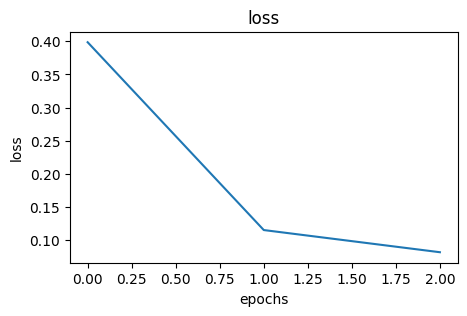

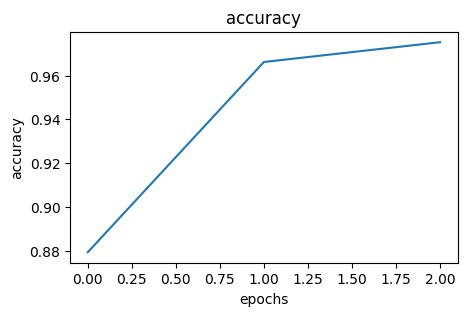

In [6]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');
plt.xlabel('epochs')
plt.ylabel('accuracy')

### Inference

With enough training epochs, the test accuracy should exceed 99%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). Even more results can be found [here](http://yann.lecun.com/exdb/mnist/).

In [7]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test_reshaped, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 2s - loss: 0.0420 - accuracy: 0.9863 - 2s/epoch - 6ms/step
accuracy: 98.63%
CPU times: user 7.58 s, sys: 592 ms, total: 8.17 s
Wall time: 2.05 s


We can also again check the confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test_reshaped)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[ 974    1    1    0    0    0    2    1    1    0]
 [   0 1131    1    2    0    0    1    0    0    0]
 [   1    3 1012    3    2    0    1    5    5    0]
 [   0    0    1 1004    0    1    0    2    2    0]
 [   0    0    0    0  971    0    1    0    1    9]
 [   2    0    0    6    0  880    2    0    1    1]
 [   7    3    0    1    4    4  937    0    2    0]
 [   1    4    8    4    0    0    0 1003    1    7]
 [   5    1    2    2    3    3    0    3  948    7]
 [   3    5    0    3    6    3    0    2    2  985]]

Classification accuracy for each class:

0: 0.9939
1: 0.9965
2: 0.9806
3: 0.9941
4: 0.9888
5: 0.9865
6: 0.9781
7: 0.9757
8: 0.9733
9: 0.9762


### More verbose training

This approach explicitly handles the looping over data. It will be helpful this afternoon for diving in and optimizing


In [9]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [10]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [11]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(60000/batch_size)
        dataset.shuffle(60000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 28, 28, 1])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [12]:
def train_network(_batch_size, _n_training_epochs, _lr):

    mnist_model = MNISTClassifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, mnist_model, opt)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(60000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 47.7 seconds for epoch #0
beginning epoch 1
took 46.5 seconds for epoch #1
beginning epoch 2
took 46.0 seconds for epoch #2


## Advanced networks

### ResNet

Deeper and deeper networks that stack convolutions end up with smaller and smaller gradients in early layers. ResNets use additional skip connections where the output layer H(x) from being f(w x + b) or f(x) to be f(x) + x. This avoids vanishing gradient problem and results in smoother loss functions. Refer [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) and [ResNet loss visualization paper](https://arxiv.org/pdf/1712.09913.pdf) for more information.
 
![ResNet](images/ResNet.png) Image credit: [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)


### U-Nets 
U-NET is a convolution based neural network architecture orginally developed for biomedical image segmentation tasks. It has an encoder-decoder architecture with skip connections in between them. 

![U-Nets](images/U-Nets.png) Image credit: [ResNet paper](https://arxiv.org/pdf/1505.04597.pdf)

### ViTs

CNNs are prone to translation invariance and a locally restricted receptive field. Transformers are used instead, but they are operate on sequences! So the images are split into patches and flattened. Use linear embeddings and positional embeddings and feed it to a encoder based treansformer model. 
![ViTs](images/ViT.gif) Image credit: [Google Blog](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)